# 3.1 New Embodiment Finetuning Tutorial (Python API)

This provides a step-by-step guide on how to finetune GR00T-N1.5 with our python API, the G1 Block Stacking Dataset is used as an example.

This is a more detailed version of the [3_0_new_embodiment_finetuning.md](3_0_new_embodiment_finetuning.md) tutorial, which explains in-depth the details of configuring the dataset, transforms, and finetuning.


---

## Step 1: Dataset

Loading any dataset for finetuning can be done in 2 steps:
- 1.1: Defining the modality configs and transforms for the dataset
- 1.2: Loading the dataset using the `LeRobotSingleDataset` class

### Step: 1.0 Download the dataset

- Download the dataset from: https://huggingface.co/datasets/unitreerobotics/G1_BlockStacking_Dataset
- copy over the `examples/unitree_g1_blocks__modality.json` to the dataset `<DATASET_PATH>/meta/modality.json`
  - This provides additional information about the state and action modalities to make it "GR00T-compatible"
  - `cp examples/unitree_g1_blocks__modality.json datasets/G1_BlockStacking_Dataset/meta/modality.json`


**Understanding the Modality Configs**

This file provides detailed metadata about state and action modalities, enabling:

- **Separate Data Storage and Interpretation:**
  - **State and Action:** Stored as concatenated float32 arrays. The `modality.json` file supplies the metadata necessary to interpret these arrays as distinct, fine-grained fields with additional training information.
  - **Video:** Stored as separate files, with the configuration file allowing them to be renamed to a standardized format.
  - **Annotations:** Keeps track of all annotation fields. If there are no annotations, do not include the `annotation` field in the configuration file.
- **Fine-Grained Splitting:** Divides the state and action arrays into more semantically meaningful fields.
- **Clear Mapping:** Explicit mapping of data dimensions.
- **Sophisticated Data Transformations:** Supports field-specific normalization and rotation transformations during training.

#### Schema

```json
{
    "state": {
        "<state_name>": {
            "start": <int>,         // Starting index in the state array
            "end": <int>,           // Ending index in the state array
        }
    },
    "action": {
        "<action_name>": {
            "start": <int>,         // Starting index in the action array
            "end": <int>,           // Ending index in the action array
        }
    },
    "video": {
        "<video_name>": {}  // Empty dictionary to maintain consistency with other modalities
    },
    "annotation": {
        "<annotation_name>": {}  // Empty dictionary to maintain consistency with other modalities
    }
}
```

Example is shown in `getting_started/examples/unitree_g1_blocks__modality.json`. This file is located in the `meta` folder of the lerobot dataset.


Generate the Stats (`meta/metadata.json`) by running the following command:
```bash
python scripts/load_dataset.py --dataset_path ./demo_data/pick增强 --embodiment_tag new_embodiment --video-backend torchvision_av
```

In [ ]:
from gr00t.data.schema import EmbodimentTag

In [ ]:
import os
print("Current working directory:", os.getcwd())

# 使用绝对路径确保能找到数据集
dataset_path = "/Users/apple/Documents/Isaac-GR00T/demo_data/pick增强"  # 绝对路径
print("Dataset path:", dataset_path)
print("Path exists:", os.path.exists(dataset_path))

embodiment_tag = EmbodimentTag.NEW_EMBODIMENT

### Step: 1.1 Modality configs and transforms

Modality configs let you select which specific data streams to use for each input type (video, state, action, language, etc.) during finetuning, giving you precise control over which parts of your dataset are utilized.

## 🔧 ModalityConfig 详细配置说明

### 📊 数据集结构解析

根据您的 `modality.json` 文件：

```json
{
    "state": {
        "single_arm": {"start": 0, "end": 5},    // 维度 0-4: 单臂关节角度
        "gripper": {"start": 5, "end": 6}       // 维度 5: 夹爪开合状态
    },
    "action": {
        "single_arm": {"start": 0, "end": 5},   // 维度 0-4: 单臂动作指令
        "gripper": {"start": 5, "end": 6}       // 维度 5: 夹爪动作指令
    },
    "video": {
        "front": {"original_key": "observation.images.front"},  // 前置摄像头
        "wrist": {"original_key": "observation.images.usb"}     // 腕部摄像头
    },
    "annotation": {
        "human.task_description": {"original_key": "task_index"}  // 任务描述
    }
}
```

### 🎯 ModalityConfig 参数详解

#### **1. delta_indices**: 时间偏移索引
- **含义**: 相对于当前时间步的偏移量
- **例子**: 
  - `[0]`: 只使用当前时间步
  - `[0, 1]`: 使用当前和下一个时间步
  - `[-1, 0]`: 使用上一个和当前时间步
  - `[0, 1, 2, 3, 4]`: 使用当前到未来4步的数据

#### **2. modality_keys**: 数据字段选择
- **格式**: `["modality_type.field_name"]`
- **必须匹配**: modality.json 中定义的字段名

### 📋 配置模板和示例

In [24]:
from gr00t.data.dataset import ModalityConfig

# 🎯 根据您的数据集配置 ModalityConfig

print("📊 数据集字段分析:")
print("State 字段: single_arm (0-4维) + gripper (5维)")
print("Action 字段: single_arm (0-4维) + gripper (5维)")  
print("Video 字段: front (前置相机) + wrist (腕部相机)")
print("Annotation 字段: human.task_description (任务描述)")
print("-" * 50)

# 🎥 视频配置 - 选择要使用的摄像头
video_modality = ModalityConfig(
    delta_indices=[0],  # 只使用当前帧
    modality_keys=[
        "video.front",  # 前置摄像头 (对应 observation.images.front)
        # "video.wrist"   # 腕部摄像头 (对应 observation.images.usb) - 可选
    ]
)

# 🤖 状态配置 - 选择要使用的状态信息
state_modality = ModalityConfig(
    delta_indices=[0],  # 只使用当前状态
    # delta_indices=[-1, 0],  # 可选: 使用上一步和当前状态 (增加历史信息)
    modality_keys=[
        "state.single_arm",  # 单臂关节状态 (0-4维)
        "state.gripper"      # 夹爪状态 (5维)
    ]
)

# 🎮 动作配置 - 预测未来动作序列
action_modality = ModalityConfig(
    # 预测未来16步的动作 (动作序列长度)
    delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    modality_keys=[
        "action.single_arm",  # 单臂动作指令 (0-4维)
        "action.gripper"      # 夹爪动作指令 (5维)
    ]
)

# 💬 语言配置 - 任务描述
language_modality = ModalityConfig(
    delta_indices=[0],  # 任务描述通常不随时间变化
    modality_keys=[
        "annotation.human.task_description"  # 任务描述 (对应 task_index)
    ]
)

# 📦 组合所有配置
modality_configs = {
    "video": video_modality,
    "state": state_modality, 
    "action": action_modality,
    "language": language_modality,
}
modality_config=modality_configs #新embedding的输入信息对应表
print("✅ ModalityConfig 配置完成:")
print(f"  📹 Video: {video_modality.modality_keys} (时间步: {video_modality.delta_indices})")
print(f"  🤖 State: {state_modality.modality_keys} (时间步: {state_modality.delta_indices})")
print(f"  🎮 Action: {action_modality.modality_keys} (时间步: {len(action_modality.delta_indices)}步预测)")
print(f"  💬 Language: {language_modality.modality_keys} (时间步: {language_modality.delta_indices})")

print("\n🔍 配置说明:")
print("- Video: 使用前置摄像头的当前帧")
print("- State: 使用当前时刻的机械臂和夹爪状态")
print("- Action: 预测未来16步的动作序列")
print("- Language: 使用任务描述指导动作生成")

📊 数据集字段分析:
State 字段: single_arm (0-4维) + gripper (5维)
Action 字段: single_arm (0-4维) + gripper (5维)
Video 字段: front (前置相机) + wrist (腕部相机)
Annotation 字段: human.task_description (任务描述)
--------------------------------------------------
✅ ModalityConfig 配置完成:
  📹 Video: ['video.front'] (时间步: [0])
  🤖 State: ['state.single_arm', 'state.gripper'] (时间步: [0])
  🎮 Action: ['action.single_arm', 'action.gripper'] (时间步: 16步预测)
  💬 Language: ['annotation.human.task_description'] (时间步: [0])

🔍 配置说明:
- Video: 使用前置摄像头的当前帧
- State: 使用当前时刻的机械臂和夹爪状态
- Action: 预测未来16步的动作序列
- Language: 使用任务描述指导动作生成


### 🛠️ ModalityConfig 配置变体

根据不同的训练需求，您可以调整配置：

#### **场景1: 单摄像头 + 短期预测**
```python
video_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["video.front"]  # 只用前置相机
)
action_modality = ModalityConfig(
    delta_indices=[0, 1, 2, 3, 4],  # 只预测5步
    modality_keys=["action.single_arm", "action.gripper"]
)
```

#### **场景2: 双摄像头 + 历史状态**
```python
video_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["video.front", "video.wrist"]  # 使用两个摄像头
)
state_modality = ModalityConfig(
    delta_indices=[-2, -1, 0],  # 使用历史2步 + 当前状态
    modality_keys=["state.single_arm", "state.gripper"]
)
```

#### **场景3: 只训练机械臂(不含夹爪)**
```python
state_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["state.single_arm"]  # 只用机械臂状态
)
action_modality = ModalityConfig(
    delta_indices=[0, 1, 2, 3, 4, 5, 6, 7],
    modality_keys=["action.single_arm"]  # 只预测机械臂动作
)
```

#### **场景4: 无语言指导的训练**
```python
# 完全移除 language_modality，不使用任务描述
modality_configs = {
    "video": video_modality,
    "state": state_modality,
    "action": action_modality,
    # "language": language_modality,  # 注释掉语言模态
}
```

In [25]:
from gr00t.data.transform.base import ComposedModalityTransform
from gr00t.data.transform import VideoToTensor, VideoCrop, VideoResize, VideoColorJitter, VideoToNumpy
from gr00t.data.transform.state_action import StateActionToTensor, StateActionTransform
from gr00t.data.transform.concat import ConcatTransform
from gr00t.model.transforms import GR00TTransform


# select the transforms you want to apply to the data
to_apply_transforms = ComposedModalityTransform(
    transforms=[
        # video transforms
        VideoToTensor(apply_to=video_modality.modality_keys, backend="torchvision"),
        VideoCrop(apply_to=video_modality.modality_keys, scale=0.95, backend="torchvision"),
        VideoResize(apply_to=video_modality.modality_keys, height=224, width=224, interpolation="linear", backend="torchvision" ),
        VideoColorJitter(apply_to=video_modality.modality_keys, brightness=0.3, contrast=0.4, saturation=0.5, hue=0.08, backend="torchvision"),
        VideoToNumpy(apply_to=video_modality.modality_keys),

        # state transforms
        StateActionToTensor(apply_to=state_modality.modality_keys),
        StateActionTransform(apply_to=state_modality.modality_keys, normalization_modes={
            "state.single_arm": "min_max",
            "state.gripper": "min_max",
        }),

        # action transforms
        StateActionToTensor(apply_to=action_modality.modality_keys),
        StateActionTransform(apply_to=action_modality.modality_keys, normalization_modes={
            "action.single_arm": "min_max",
            "action.gripper": "min_max",
        }),

        # ConcatTransform
        ConcatTransform(
            video_concat_order=video_modality.modality_keys,
            state_concat_order=state_modality.modality_keys,
            action_concat_order=action_modality.modality_keys,
        ),
        # model-specific transform
        GR00TTransform(
            state_horizon=len(state_modality.delta_indices),
            action_horizon=len(action_modality.delta_indices),
            max_state_dim=64,
            max_action_dim=32,
        ),
    ]
)
modality_transform = to_apply_transforms #新embedding的transformer模型
print("Transforms configured for:")
print(f"  Video keys: {video_modality.modality_keys}")
print(f"  State keys: {state_modality.modality_keys}")
print(f"  Action keys: {action_modality.modality_keys}")


Transforms configured for:
  Video keys: ['video.front']
  State keys: ['state.single_arm', 'state.gripper']
  Action keys: ['action.single_arm', 'action.gripper']


### Step 1.2 Load the dataset

First we will visualize the dataset and then load it using the `LeRobotSingleDataset` class. (without transforms)

In [ ]:
from gr00t.data.dataset import LeRobotSingleDataset

train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
)


In [ ]:
# use matplotlib to visualize the images
import matplotlib.pyplot as plt
import numpy as np

print("Dataset sample keys:", train_dataset[0].keys())

# 检查视频数据的结构
sample = train_dataset[0]
video_key = "video.front"  # 使用实际存在的视频键
print(f"Video data shape: {sample[video_key].shape}")
print(f"Video data type: {type(sample[video_key])}")

images = []
for i in range(5):
    image = train_dataset[i][video_key][0]  # 使用正确的视频键
    # image is in HWC format, convert it to CHW format
    image = image.transpose(2, 0, 1)
    images.append(image)   

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, image in enumerate(images):
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].axis("off")
    axs[i].set_title(f"Frame {i}")
plt.show()

Now, we will initiate a dataset with our modality configs and transforms.

In [ ]:
train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
    transforms=to_apply_transforms,
)

**Extra Notes**:
 - We use a cached dataloader to accelerate training speed. The cached dataloader loads all data into memory, which significantly improves training performance. However, if your dataset is large or you're experiencing out-of-memory (OOM) errors, you can switch to the standard lerobot dataloader (`gr00t.data.dataset.LeRobotSingleDataset`). It uses the same API as the cached dataloader, so you can switch back and forth without any changes to your code.
 - we use torchvision_av as the video backend, the video encoding is in av instead of standard h264


### Step 2: Load the model

The training process is done in 3 steps:
- 2.1: Load the base model from HuggingFace or a local path
- 2.2: Prepare training args
- 2.3: Run the training loop

#### Step 2.1 Load the base model

We'll use the `from_pretrained_for_tuning` method to load the model. This method allows us to specify which parts of the model to tune.

In [ ]:
import os
import torch

# 检查可用的设备
if torch.cuda.is_available():
    device = "cuda"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif torch.backends.mps.is_available():
    device = "mps"
    # 设置MPS兼容性
    torch.set_default_dtype(torch.float32)
    print("Using MPS device with float32")
else:
    device = "cpu"
    print("Using CPU device")

print(f"Selected device: {device}")

In [ ]:
from gr00t.model.gr00t_n1 import GR00T_N1_5

BASE_MODEL_PATH = "nvidia/GR00T-N1.5-3B"
TUNE_LLM = False            # Whether to tune the LLM
TUNE_VISUAL = False          # Whether to tune the visual encoder
TUNE_PROJECTOR = True       # Whether to tune the projector
TUNE_DIFFUSION_MODEL = True # Whether to tune the diffusion model

model = GR00T_N1_5.from_pretrained(
    pretrained_model_name_or_path=BASE_MODEL_PATH,
    tune_llm=TUNE_LLM,  # backbone's LLM
    tune_visual=TUNE_VISUAL,  # backbone's vision tower
    tune_projector=TUNE_PROJECTOR,  # action head's projector
    tune_diffusion_model=TUNE_DIFFUSION_MODEL,  # action head's DiT
)

# 根据设备类型设置compute_dtype
if device == "cuda":
    model.compute_dtype = "bfloat16"
    model.config.compute_dtype = "bfloat16"
else:
    # 对于MPS和CPU，使用float32
    model.compute_dtype = "float32"
    model.config.compute_dtype = "float32"
    
model.to(device)

#### Step 2.2 Prepare training args

We use huggingface `TrainingArguments` to configure the training process. Here are the main parameters:

In [ ]:
from transformers import TrainingArguments

output_dir = "/tmp/gr00t_test"          # 使用临时目录
per_device_train_batch_size = 2 if device == "mps" else 8  # MPS使用更小的批次
max_steps = 10000                          # 保持较小的步数用于测试
report_to = "wandb"
dataloader_num_workers = 0 if device == "mps" else 4  # MPS不使用多进程

# 根据设备类型设置精度
use_bf16 = device == "cuda"
use_fp16 = False
tf32 = device == "cuda"

training_args = TrainingArguments(
    output_dir=output_dir,
    run_name=None,
    remove_unused_columns=False,
    deepspeed="",
    gradient_checkpointing=False,
    bf16=use_bf16,
    fp16=use_fp16,
    tf32=tf32,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=1,
    dataloader_num_workers=dataloader_num_workers,
    dataloader_pin_memory=False,
    dataloader_persistent_workers=dataloader_num_workers > 0,
    optim="adamw_torch",
    adam_beta1=0.95,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    learning_rate=1e-4,
    weight_decay=1e-5,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    logging_steps=10.0,
    num_train_epochs=300,
    max_steps=max_steps,
    save_strategy="steps",
    save_steps=10000,
    save_total_limit=8,
    report_to=report_to,
    seed=42,
    do_eval=False,
    ddp_find_unused_parameters=False,
    ddp_bucket_cap_mb=100,
    torch_compile_mode=None,
)

print(f"Training configuration:")
print(f"  Device: {device}")
print(f"  Batch size: {per_device_train_batch_size}")
print(f"  Workers: {dataloader_num_workers}")
print(f"  BF16: {use_bf16}")
print(f"  Output dir: {output_dir}")


#### Step 2.3 Initialize the training runner and run the training loop

In [ ]:
from gr00t.experiment.runner import TrainRunner

experiment = TrainRunner(
    train_dataset=train_dataset,
    model=model,
    training_args=training_args,
)

experiment.train()

We can see the 1k offline validation results vs 10k offline validation results:

**Finetuning Results on Unitree G1 Block Stacking Dataset:**

| 1k Steps | 10k Steps |
| --- | --- |
| ![1k](../media/g1_ft_1k.png) | ![10k](../media/g1_ft_10k.png) |
| MSE: 0.0181 | MSE: 0.0022 |

Loading from local path: /tmp/gr00t_test
Loading pretrained dual brain from /tmp/gr00t_test
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /tmp/gr00t_test
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 25.018618
state_joints vs time (150, 6)
gt_action_joints vs time (150, 6)
pred_action_joints vs time (150, 6)


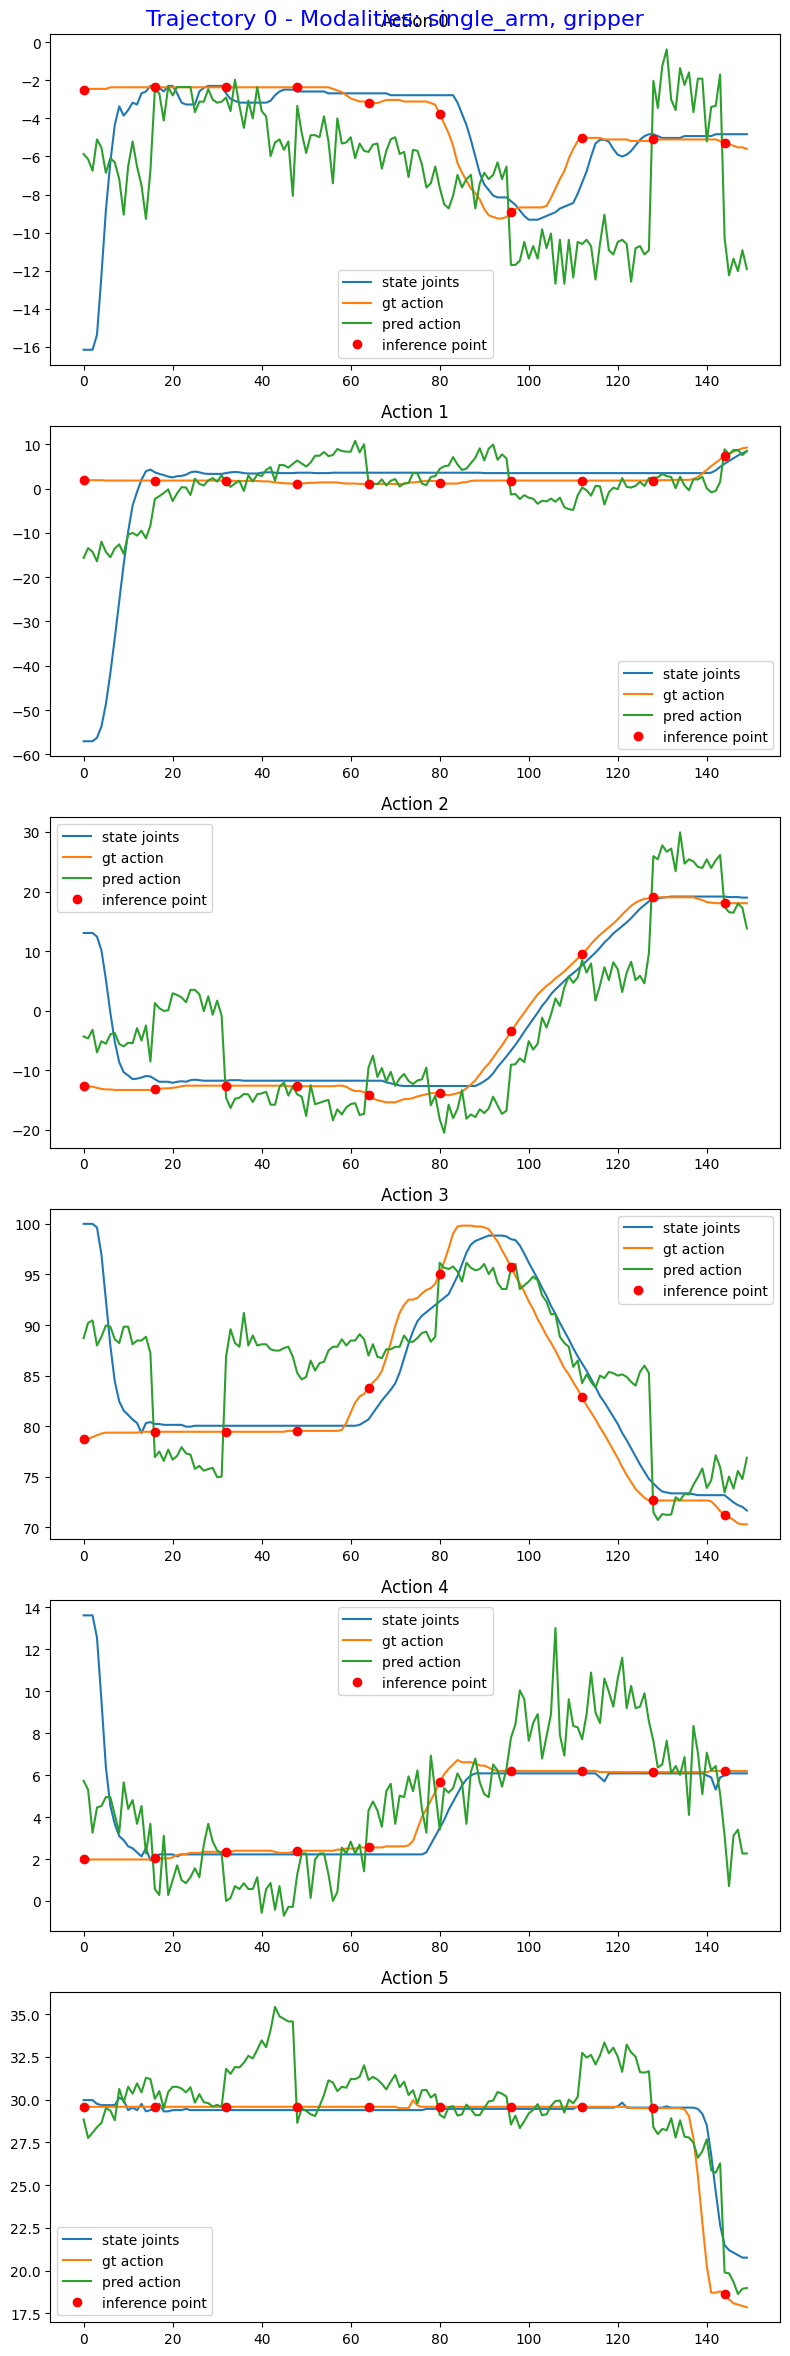

MSE loss for trajectory 0: 25.018618


In [32]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import Gr00tPolicy
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
warnings.filterwarnings("ignore")
finetuned_model_path = "/tmp/gr00t_test"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    train_dataset,
    traj_id=0,
    modality_keys=[
        "single_arm",  # 单臂关节状态 (0-4维)
        "gripper"      # 夹爪状态 (5维)
    ],
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)